In [1]:
import matplotlib.pyplot as plt
import torch
import os
import numpy as np

# Model loading
from pathlib import Path
from typing import List, Optional, Dict, Union, Callable
from ray import cloudpickle

# Dataset loading
from lie_conv.datasets import SpringDynamics
from lie_conv.dynamicsTrainer import Partial
from torch.utils.data import DataLoader
from torchdiffeq import odeint
from oil.utils.utils import FixedNumpySeed, LoaderTo
from oil.datasetup.datasets import split_dataset

wd = str(os.getcwd())

def load_checkpoint_from_path(checkpoint_to_load: Union[str, Path]) -> Dict:
    """Utility function to load a checkpoint Dict from a path."""
    checkpoint_path = Path(checkpoint_to_load).expanduser()
    if not checkpoint_path.exists():
        raise ValueError(f"Checkpoint path {checkpoint_path} does not exist.")
    with checkpoint_path.open("rb") as f:
        return cloudpickle.load(f)

def getQP(tzs):
    zs = tzs[0]
    D = zs.shape[-1]
    tsteps = zs.shape[0]
    qs = zs[:,:D//2].reshape(tsteps,6,-1)
    ps = zs[:,D//2:].reshape(tsteps,6,-1)
    return qs,ps

def plotTrajectories(zs,color = 'blue',label = None):
    qs,ps = getQP(zs)
    x,y = qs[-1].T    
    qs = torch.permute(qs,(2,1,0))
    xq,yq = qs
    for i in range(len(xq)): # iterating over particles here
        plt.plot(xq[i],yq[i],color = color)
    plt.scatter(x,y,label = label, color = color)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def sigfigRound(i,n=3):
    return '{:g}'.format(float('{:.{p}g}'.format(i, p=n)))

In [2]:
# set up to read LieTransformer results
import forge
from forge import load_from_checkpoint
from forge import flags
import forge.experiment_tools as fet
from os import path as osp

# Job config
flags.DEFINE_string('data_config', './lie_transformer/configs/dynamics/spring_dynamics_data.py',
                    'Path to a data config file.')
flags.DEFINE_string('model_config', './lie_transformer/configs/dynamics/eqv_transformer_model.py',
                    'Path to a model config file.')
flags.DEFINE_string('results_dir', './lie_transformer/checkpoints',
                    'Top directory for all experimental results.')
flags.DEFINE_string('run_name', 'test_run',
                    'Name of this job and name of results folder.')
flags.DEFINE_boolean('resume', True, 'Tries to resume a job if True.')

flags.DEFINE_boolean("debug", False, "Track and show on tensorboard more metrics.")

config = forge.config()

## Data generation & intake

In [3]:
# Generate some test data
tsteps = 50
dataset = SpringDynamics(n_systems=150,chunk_len = tsteps); # generate a new trajectory each time
testdata = DataLoader(dataset,batch_size = 1,shuffle = False)

150
/Users/gorg/datasets/ODEDynamics/SpringDynamics/spring_2D_150_particles_6_train.pz


In [4]:
# grab a single sample trajectory, for plotting 
data = list(testdata)[0]
features,true_zs = data
z0,sys_params,ts = features # what we feed into model
true_qs,true_ps = getQP(true_zs) # corret outcome of dynamics

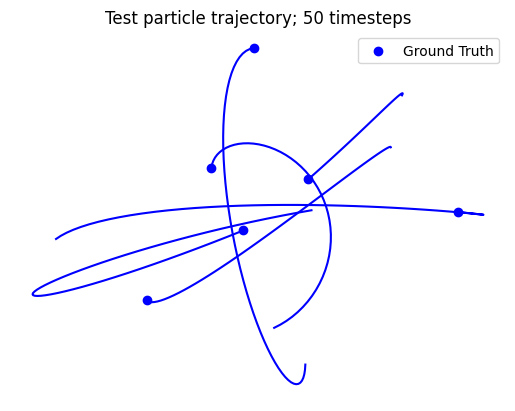

In [5]:
plotTrajectories(true_zs,label = 'Ground Truth')
plt.legend()
plt.axis('off')
plt.title("Test particle trajectory; 50 timesteps")
# plt.savefig('talk_images/true_trajs.png',bbox_inches = 'tight',transparent = True,dpi=300)
plt.show()

# Model import and usage

## Fully-connected model

In [6]:
# load and evaluate fully-connected dynamics model
from lie_conv.dynamicsTrainer import FC

FC_model_path = "./LieConv/runs/dynamics_examples/c100_newFC.state"

FC_wts = load_checkpoint_from_path(FC_model_path)

FC_cfg = {'k':384,'num_layers':4}

FCmodel = FC(sys_dim=dataset.sys_dim,d=dataset.space_dim,**FC_cfg)
FCmodel.load_state_dict(FC_wts['model_state'])
FCparams = count_parameters(FCmodel)
FCparams

466968

In [7]:
# infer with model on test data
with torch.no_grad():
    dynamics = Partial(FCmodel, sysP=sys_params.float())
    FCpred_zs = odeint(dynamics, z0.float(), ts[0].float(), rtol=1e-4, method='rk4')
    FCpred_zs = FCpred_zs.permute(1, 0, 2)
FC_MSE = (FCpred_zs - true_zs).pow(2).mean().item()
print("MSE:",FC_MSE)
FC_wts['outcome']

MSE: 14.991679160499896


,Minibatch_Loss,Train_MSE,lr0,nfe,test_MSE,val_MSE
439,0.005289,0.005043,0.00804,16.0,0.02862,0.025728


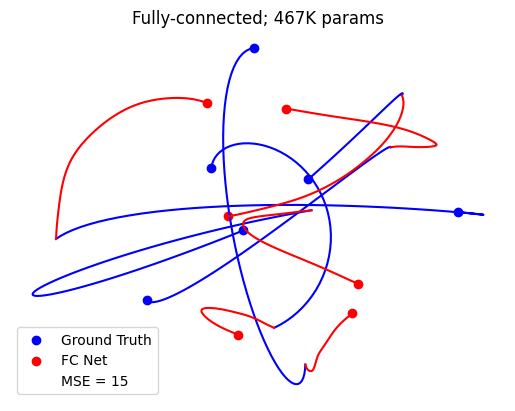

In [9]:
plotTrajectories(true_zs,label = 'Ground Truth')
plotTrajectories(FCpred_zs,color = 'red',label = 'FC Net')
plt.plot([], [], ' ', label="MSE = {}".format(sigfigRound(FC_MSE)))
plt.legend()
plt.axis('off')
plt.title("Fully-connected; {}K params".format(round(FCparams/1000)))
# plt.savefig('talk_images/FC_preds.png',bbox_inches = 'tight',transparent = True,dpi=300)
plt.show()

## Hamiltonian fully connected

In [10]:
from lie_conv.dynamicsTrainer import HFC

HFC_model_path = "./LieConv/runs/dynamics_examples/c100_newHFC.state"
HFC_wts = load_checkpoint_from_path(HFC_model_path)

HFC_cfg = {'k':384,'num_layers':4}

HFCmodel = HFC(sys_dim=dataset.sys_dim,d=dataset.space_dim,**HFC_cfg)
HFCmodel.load_state_dict(HFC_wts['model_state'])
HFCparams = count_parameters(HFCmodel)

In [11]:
# infer with model on test data
with torch.no_grad():
    dynamics = Partial(HFCmodel, sysP=sys_params.float())
    HFCpred_zs = odeint(dynamics, z0.float(), ts[0].float(), rtol=1e-4, method='rk4')
    HFCpred_zs = HFCpred_zs.permute(1, 0, 2)
HFC_MSE = (HFCpred_zs - true_zs).pow(2).mean().item()
print("MSE:",HFC_MSE)
HFC_wts['outcome']

MSE: 0.010064070833789594


,Minibatch_Loss,Train_MSE,lr0,nfe,test_MSE,val_MSE
1488,0.000146,0.000135,0.00001,16.0,0.002878,0.001047


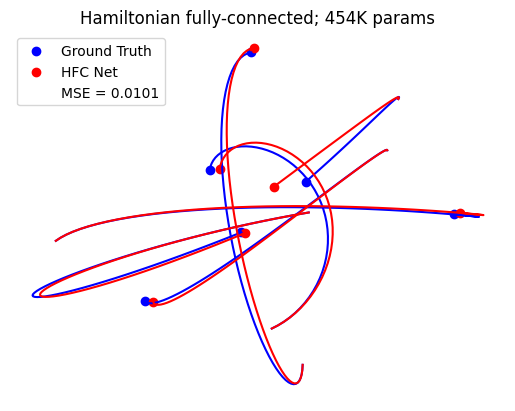

In [12]:
plotTrajectories(true_zs,label = 'Ground Truth')
plotTrajectories(HFCpred_zs,color = 'red',label = 'HFC Net')
plt.plot([], [], ' ', label="MSE = {}".format(sigfigRound(HFC_MSE)))
plt.legend()
plt.axis('off')
plt.title("Hamiltonian fully-connected; {}K params".format(round(HFCparams/1000)))
# plt.savefig('talk_images/HFC_preds.png',bbox_inches = 'tight',transparent = True,dpi=300)
plt.show()

## LieConv T2 run

In [13]:
from lie_conv.dynamicsTrainer import HLieResNet
from lie_conv.lieGroups import T

T2_model_path = "./LieConv/runs/dynamics_examples/c100_T2run.state"
T2_wts = load_checkpoint_from_path(T2_model_path)

T2_cfg = {'group':T(2),'k':384,'num_layers':4}

T2model = HLieResNet(sys_dim=dataset.sys_dim,d=dataset.space_dim,**T2_cfg)
T2model.load_state_dict(T2_wts['model_state'])
T2params = count_parameters(T2model)
T2params

895297

In [14]:
# infer with model on test data
with torch.no_grad():
    dynamics = Partial(T2model, sysP=sys_params.float())
    T2pred_zs = odeint(dynamics, z0.float(), ts[0].float(), rtol=1e-4, method='rk4')
    T2pred_zs = T2pred_zs.permute(1, 0, 2)
T2_MSE = (T2pred_zs - true_zs).pow(2).mean().item()
print("MSE:",T2_MSE)
T2_wts['outcome']

MSE: 0.00018387955839015735


,Minibatch_Loss,Train_MSE,lr0,nfe,test_MSE,val_MSE
1441,0.000025,0.000015,0.000004,16.0,0.000573,0.000033


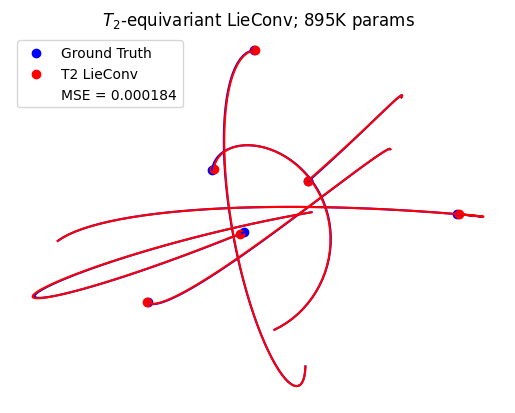

In [15]:
plotTrajectories(true_zs,label = 'Ground Truth')
plotTrajectories(T2pred_zs,color = 'red',label = 'T2 LieConv')
plt.plot([], [], ' ', label="MSE = {}".format(sigfigRound(T2_MSE)))
plt.legend()
plt.axis('off')
plt.title(r"$T_2$-equivariant LieConv; {}K params".format(round(T2params/1000)))
# plt.savefig('talk_images/T2_preds.png',bbox_inches = 'tight',transparent = True,dpi=300)
plt.show()


## LieConv SO(2) Run

In [16]:
from lie_conv.dynamicsTrainer import HLieResNet
from lie_conv.lieGroups import SO2

SO2_model_path = "./LieConv/runs/dynamics_examples/c100_SO2run.state"
SO2_wts = load_checkpoint_from_path(SO2_model_path)

SO2_cfg = {'group':SO2(),'k':384,'num_layers':4}

SO2model = HLieResNet(sys_dim=dataset.sys_dim,d=dataset.space_dim,**SO2_cfg)
SO2model.load_state_dict(SO2_wts['model_state'])
SO2params = count_parameters(SO2model)

In [17]:
# infer with model on test data
with torch.no_grad():
    dynamics = Partial(SO2model, sysP=sys_params.float())
    SO2pred_zs = odeint(dynamics, z0.float(), ts[0].float(), rtol=1e-4, method='rk4')
    SO2pred_zs = SO2pred_zs.permute(1, 0, 2)
SO2_MSE = (SO2pred_zs - true_zs).pow(2).mean().item()
print("MSE:",SO2_MSE)
SO2_wts['outcome']

MSE: 0.11406515195954235


,Minibatch_Loss,Train_MSE,lr0,nfe,test_MSE,val_MSE
63,0.015236,0.010269,0.000996,16.0,0.011392,0.01188


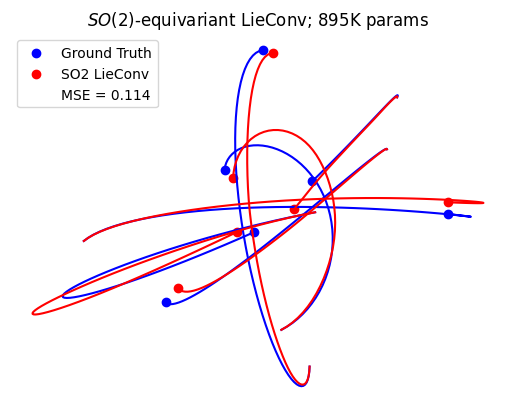

In [18]:
plotTrajectories(true_zs,label = 'Ground Truth')
plotTrajectories(SO2pred_zs,color = 'red',label = 'SO2 LieConv')
plt.plot([], [], ' ', label="MSE = {}".format(sigfigRound(SO2_MSE)))
plt.legend()
plt.axis('off')
plt.title(r"$SO(2)$-equivariant LieConv; {}K params".format(round(SO2params/1000)))
# plt.savefig('talk_images/S02_preds.png',bbox_inches = 'tight',transparent = True,dpi=300)
plt.show()


## LieTransformer Run

In [19]:
logdir = osp.join(config.results_dir, config.run_name)
logdir, resume_checkpoint = fet.init_checkpoint(
    logdir, config.data_config, config.model_config, True)

checkpoint_name = osp.join(logdir, 'model.ckpt-early_stop')

# Load transformer model
checkpoint_name

loading flags from ./lie_transformer/configs/dynamics/eqv_transformer_model.py
loading flags from ./lie_transformer/configs/dynamics/spring_dynamics_data.py


'./lie_transformer/checkpoints/test_run/4/model.ckpt-early_stop'

In [20]:
config.model_config

'../lie-transformer/configs/dynamics/eqv_transformer_model.py'

In [21]:
LTmodel,LTmodelname = fet.load('./lie_transformer/configs/dynamics/eqv_transformer_model.py', config)
LT_wts = torch.load(checkpoint_name)
LTmodel.load_state_dict(LT_wts['model_state_dict'])

LTparams = count_parameters(LTmodel)
LTparams

Loading 'eqv_transformer_model' from ./lie_transformer/configs/dynamics/eqv_transformer_model.py


841641

In [22]:
# parse data for input to LieTransformer
LTinit,LTtruezs = data
LTinit = [x.float() for x in LTinit]
LTtruezs = LTtruezs.float()
LTdata = [LTinit,LTtruezs]

# do inference
with torch.no_grad():
    LTpreds = LTmodel(LTdata)

LT_MSE = LTpreds['mse'].item()
print("MSE:",LT_MSE)

MSE: 0.0006500683957710862


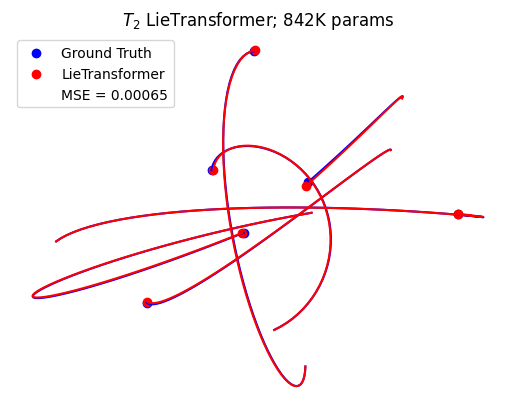

In [23]:
plotTrajectories(true_zs,label = 'Ground Truth')
plotTrajectories(LTpreds['prediction'],color = 'red',label = 'LieTransformer')
plt.plot([], [], ' ', label="MSE = {}".format(sigfigRound(LT_MSE)))
plt.legend()
plt.axis('off')
plt.title(r"$T_2$ LieTransformer; {}K params".format(round(LTparams/1000)))
# plt.savefig('talk_images/LT_preds.png',bbox_inches = 'tight',transparent = True,dpi=300)
plt.show()

# Model comparison

In [24]:
scores = [FC_MSE,HFC_MSE,SO2_MSE,T2_MSE,LT_MSE]
labels = ['Fully-connected','Hamiltonian Net',"SO2-Equiv LieNet","T2-Equiv LieNet","LieTransformer"]

In [25]:
print("Model MSE on test data:")
for i in range(len(scores)):
    print(labels[i],scores[i])

Model MSE on test data:
Fully-connected 14.991679160499896
Hamiltonian Net 0.010064070833789594
SO2-Equiv LieNet 0.11406515195954235
T2-Equiv LieNet 0.00018387955839015735
LieTransformer 0.0006500683957710862


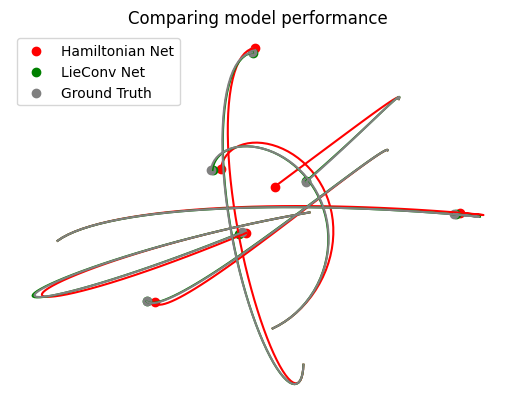

In [26]:
plotTrajectories(HFCpred_zs,color = 'red',label = 'Hamiltonian Net')
plotTrajectories(T2pred_zs,color = 'green',label = 'LieConv Net')
# plotTrajectories(SO2pred_zs,color = 'blue',label = 'LieConv SO2 Net')
plotTrajectories(true_zs,label = 'Ground Truth',color = 'gray')
plt.legend()
plt.axis('off')
plt.title("Comparing model performance")
plt.show()